In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.
import branchingdnn as branching

In [7]:
(train_ds, test_ds, validation_ds) = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True)

augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [14]:
def calcEntropy(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        if isinstance(y_hat, list):
            y_hat = np.array(y_hat)
        sum_entropy = 0
        if y_hat.ndim >1:
            return list(map(calcEntropy,y_hat))
        for i in range(len(y_hat)):
            if y_hat[i] != 0: # log of zero is undefined, see MacKay's book "Information Theory, Inference, and Learning Algorithms"  for more info on this workaround reasoning.
                entropy =y_hat[i] * math.log(y_hat[i],2)
                sum_entropy +=  entropy

        return -sum_entropy
    
def calcEntropy_Tensors(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
#             results = tf.clip_by_value(results, -1e12, 1e12)
#             print("res ", results)
            return tf.reduce_sum(y_hat * results)

        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies
    
def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
#     num = tf.math.log(y_hat)
# #     print("num",num)
#     dem = tf.math.log(tf.constant(2, dtype=y_hat.dtype))
# #     print("dem",dem)
#     E = num / dem
# #     print("E",E)
#     P = y_hat * E
# #     print("p",P)
#     mean = tf.reduce_mean(tf.boolean_mask(P, tf.math.is_finite(P)))
#     print("mean",mean)
#     sumEntropies = mean
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies
    
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)

    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)

    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

In [9]:
class CrossEntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(CrossEntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = softplus_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            softmax = tf.nn.softmax(outputs)
            evidence = self.evidence (outputs)
            alpha = evidence + 1
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
          
            # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            
            self.add_metric(evidence, name=self.name+"_evidence",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs

In [12]:
outputs =[]
targets = tf.keras.Input(shape=(10,),name='targets')
inputs = tf.keras.Input(shape=(227,227,3))
x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x, targets)

# model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
model = tf.keras.Model(inputs=[inputs,targets], outputs=output, name="alexnet")
# loss_fn = evidence_crossentropy()
model.compile( loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# model.summary()

In [13]:
import time
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
checkpoint = tf.keras.callbacks.ModelCheckpoint("alexNetv6_evidence_test.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto')
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
model.fit(train_ds,
        epochs=10,
        validation_data=validation_ds,
        validation_freq=1,
        # batch_size=1,
        verbose=1,
        callbacks=[tensorboard_cb,checkpoint])

Epoch 1/10
1406/1406 [==============================] - 97s 57ms/step - loss: 2.1473 - accuracy: 0.3907 - endpoint_2_evidence: 1.1364 - endpoint_2_mean_ev_succ: 11.8065 - endpoint_2_mean_ev_fail: 10.9784 - val_loss: 1.2984 - val_accuracy: 0.5413 - val_endpoint_2_evidence: 1.2443 - val_endpoint_2_mean_ev_succ: 12.9620 - val_endpoint_2_mean_ev_fail: 11.8354

Epoch 00001: val_loss improved from inf to 1.29842, saving model to alexNetv6_evidence_test.hdf5
Epoch 2/10
1406/1406 [==============================] - 88s 52ms/step - loss: 1.1596 - accuracy: 0.5888 - endpoint_2_evidence: 1.2289 - endpoint_2_mean_ev_succ: 12.8233 - endpoint_2_mean_ev_fail: 11.4765 - val_loss: 1.0466 - val_accuracy: 0.6386 - val_endpoint_2_evidence: 1.3003 - val_endpoint_2_mean_ev_succ: 13.8206 - val_endpoint_2_mean_ev_fail: 11.5978

Epoch 00002: val_loss improved from 1.29842 to 1.04657, saving model to alexNetv6_evidence_test.hdf5
Epoch 3/10
1406/1406 [==============================] - 87s 51ms/step - loss: 0.9408

In [17]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay

    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)

        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C

    return  cross_entropy_evidence

outputs =[]
targets = tf.keras.Input(shape=(10,),name='targets')
inputs = tf.keras.Input(shape=(227,227,3))
x = tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = CrossEntropyEndpoint(10, name=tf.compat.v1.get_default_graph().unique_name("endpoint"))(x, targets)

# model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
model = tf.keras.Model(inputs=[inputs,targets], outputs=output, name="alexnet")
loss_fn = loss_function()
model.compile( loss=loss_fn, optimizer=tf.optimizers.SGD(lr=0.001,momentum=0.9), metrics=['accuracy'])
# model.summary()



In [18]:
import time
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
checkpoint = tf.keras.callbacks.ModelCheckpoint("alexNetv6_evidence_test_2.hdf5", monitor='val_loss',verbose=1,save_best_only=True, mode='auto')
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
model.fit(train_ds,
        epochs=10,
        validation_data=validation_ds,
        validation_freq=1,
        # batch_size=1,
        verbose=1,
        callbacks=[tensorboard_cb,checkpoint])

Epoch 1/10
1406/1406 [==============================] - 92s 53ms/step - loss: 2.3053 - accuracy: 0.3700 - endpoint_4_evidence: 0.0235 - endpoint_4_mean_ev_succ: 0.2773 - endpoint_4_mean_ev_fail: 0.1981 - val_loss: 1.1693 - val_accuracy: 0.5913 - val_endpoint_4_evidence: 0.0164 - val_endpoint_4_mean_ev_succ: 0.1901 - val_endpoint_4_mean_ev_fail: 0.1255

Epoch 00001: val_loss improved from inf to 1.16926, saving model to alexNetv6_evidence_test_2.hdf5
Epoch 2/10
1406/1406 [==============================] - 89s 53ms/step - loss: 1.2093 - accuracy: 0.5683 - endpoint_4_evidence: 0.0200 - endpoint_4_mean_ev_succ: 0.2480 - endpoint_4_mean_ev_fail: 0.1311 - val_loss: 1.0863 - val_accuracy: 0.6216 - val_endpoint_4_evidence: 0.0147 - val_endpoint_4_mean_ev_succ: 0.1799 - val_endpoint_4_mean_ev_fail: 0.0930

Epoch 00002: val_loss improved from 1.16926 to 1.08630, saving model to alexNetv6_evidence_test_2.hdf5
Epoch 3/10
1406/1406 [==============================] - 94s 56ms/step - loss: 0.9834 - a

In [93]:
def collectEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    Outputs = pd.DataFrame()
    output_names=["mainExit"]
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        result = model.test_on_batch(x,y)
#         print(x)
        # print("accuracy:", x[4], "evidence:",x[5], "uncert:",x[6])
        
        "format should be: loss, dense2_loss, branch_loss,dense2_acc, branch_acc, branch_evid, branch_uncert, branch_mean_avg, branch_mean_succ, branch_mean_fail "
        
        pClass.append(tf.argmax(y,1).numpy()[0])
        pEvidence.append(result[2])
        pAcc.append(result[1])       
        # pUncertainty.append(result[3])      
        # if (x[5]== 0.0):
            # print("accuracy:", x[4], "evidence:",x[5])
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"overlap":0})
    return Predictions

def displayEvidence(Predictions):
    output_names=["mainExit"]
    Outputs=pd.DataFrame()
    Predictions["Acc"]=Predictions["Acc"].astype('bool')
    acc = Predictions["Acc"].value_counts()
    print(acc)
    print((acc.loc[True] , acc.loc[False]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = mean + std
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    # Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    print(acc)
    for i,name in enumerate(output_names):
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                # "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                # "Incorrects_overlap":Incorrects_overlap,
                },index=[i]))

    # fig, axs = plt.subplots(1, 2)
    plt.suptitle('Horizontally stacked subplots')
    plt.scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    plt.scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    plt.plot(np.repeat(E_threshold,11),'b--')
    plt.title("evidence")


    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs
    


In [82]:

# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# # print(y_train)
# K= 10 # number of classes
# test_labels = tf.keras.utils.to_categorical(test_labels,10)
# shuffle_size = 22500
# batch_size=1
# test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# def augment_images(image, label,input_size=(227,227), channel_first = False):
#             image = tf.image.resize(image,input_size)
#             if channel_first:
#                 image = tf.transpose(image, [2, 0, 1])
#             return image, label
# test_ds_size = len(list(test_ds))
# test_ds = (test_ds.map(augment_images))
# t_target = tf.data.Dataset.from_tensor_slices((test_labels))
# test_ds = tf.data.Dataset.zip((test_ds,t_target))
# test_ds = (test_ds.batch(batch_size=1, drop_remainder=True))

# Predictions = collectEvidence(model,test_ds)
# print(Predictions.head())
# # Predictions.size

True     7487
False    2513
Name: Acc, dtype: int64
(7487, 2513)
True     7487
False    2513
Name: Acc, dtype: int64


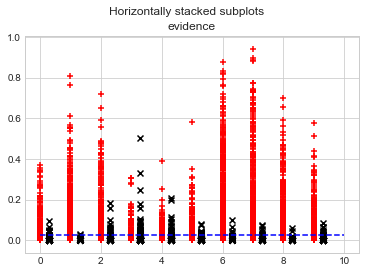

,Branch Name,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,rejected_correct,rejected_incorrect
0,mainExit,0.7487,0.026318,0.3039,2923,116,0.96183,4564,2397


In [83]:
displayEvidence(Predictions)


In [87]:
model_2 = tf.keras.models.load_model('alexNetv6_evidence_test.hdf5',
    custom_objects={"CrossEntropyEndpoint":CrossEntropyEndpoint,"crossEntropy_loss":loss_function()})

In [89]:
Predictions_2 = collectEvidence(model_2,test_ds)

10000


True     7833
False    2167
Name: Acc, dtype: int64
(7833, 2167)
True     7833
False    2167
Name: Acc, dtype: int64


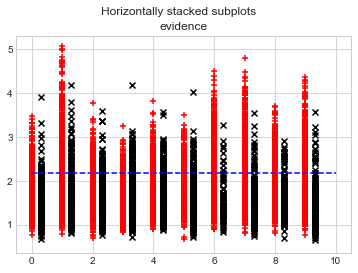

,Branch Name,Accuracy,E_Threshold,acceptance_rate,accepted_correct,accepted_incorrect,accepted_accuracy,rejected_correct,rejected_incorrect
0,mainExit,0.7833,2.18943,0.3108,2787,321,0.896718,5046,1846


In [90]:
displayEvidence(Predictions_2)

In [139]:
def collectEntropy(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    Outputs = pd.DataFrame()
    output_names=["mainExit"]
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
#     for i in range(100):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        result = model.predict(x)
        pClass.append(tf.argmax(y,1).numpy()[0])
        pred= (tf.nn.softmax(result)[0])

        pEvidence.append(calcEntropy_Tensors(pred).numpy())
        if np.argmax(pred) == np.argmax(y):
            pAcc.append(1)       
        else:
            pAcc.append(0)
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"overlap":0})
    return Predictions

def displayEvidence(Predictions):
    output_names=["mainExit"]
    Outputs=pd.DataFrame()
    Predictions["Acc"]=Predictions["Acc"].astype('bool')
    acc = Predictions["Acc"].value_counts()
    print(acc)
    print((acc.loc[True] , acc.loc[False]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = mean + std
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    # Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    print(acc)
    for i,name in enumerate(output_names):
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[i],
                "Accuracy":(acc.loc[True] /  (acc.loc[True] + acc.loc[False])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                # "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                # "Incorrects_overlap":Incorrects_overlap,
                },index=[i]))

    # fig, axs = plt.subplots(1, 2)
    plt.suptitle('Horizontally stacked subplots')
    plt.scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    plt.scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    plt.plot(np.repeat(E_threshold,11),'b--')
    plt.title("evidence")


    # fig.set_size_inches(10, 10)
    plt.show()
    return Outputs
    


In [140]:
Entropy_predictions = collectEntropy(model_2,test_ds)


10000
class [3]
entropy 0.49807447
class [8]
entropy 0.10007039
class [8]
entropy 1.1932665
class [0]
entropy 0.30652222
class [6]
entropy 0.03291796
class [6]
entropy 0.006064197
class [1]
entropy 1.5048445
class [6]
entropy 0.75782156
class [3]
entropy 1.4742785
class [1]
entropy 0.56588405
class [0]
entropy 2.0713391
class [9]
entropy 2.9550696e-07
class [5]
entropy 2.0650678
class [7]
entropy 0.00020793654
class [9]
entropy 0.006792374
class [8]
entropy 0.3056397
class [5]
entropy 1.1135154
class [7]
entropy 0.39188662
class [8]
entropy 3.4864428e-05
class [6]
entropy 1.5582455e-05


KeyboardInterrupt: 

(100,)


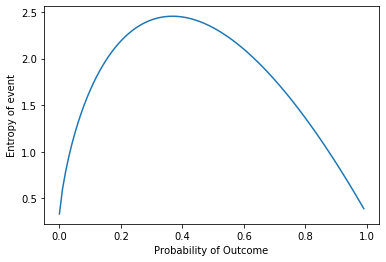

In [191]:
#sum entropy 
import pandas as pd
def entropy(x):
    return -(x * math.log(x))
# Data for plotting
t = np.arange(0.00001, 1, 0.01)
print(t.shape)
t_ = np.full((100,), .1)
df = pd.DataFrame([t,t,t_,t,t])
# print(df.transpose())
p = df.apply(calcEntropy,axis=0)
# print(p)
# print(p)
fig, ax = plt.subplots()
ax.plot(t, p)
ax.set(xlabel='Probability of Outcome',ylabel='Entropy of event')

plt.show()


In [85]:
y_true = [0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

crossE:  0.039609063


In [246]:
y_true = [0,1,0,0,0,0]
y_pred = [.99,.01, .01, .0, .01, .01]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.CategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

crossE:  4.634729


In [103]:
y_true = [0]
y_pred = [.0,.01, .9, .0, .0, .0]
ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = ent *1
print("Loss: ",loss)

y_hat [0.0, 0.01, 0.9, 0.0, 0.0, 0.0]
Entropy:  0.20324134599829222
Loss:  0.20324134599829222


In [305]:
y_true = [[0],[0],[0]]
y_pred = [[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
y_pred = [[.9,.0,.0,.0,.0,.0,],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]
# y_pred = [.1,.1, .1, .1, .1, .1]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossE: ",crossE)

''' When the answer is correct, CrossE goes down
    When 
    When its wrong, Entropy High
    When its right, Entropy Low
    
    so penalize being right with low entropy and reward being right with high entropy
    
    
    OORRRR train a second model for a branch to determine if you are going to get it right or not?
    Isn't that what ResNet Did? you calculate if the blocks will contribute, was it block drop?
    Binary classification,
    could be done at the branch end as a separate evaulator, using the entropy score and the input to the branch as inputs?
'''


ent = calcEntropy(y_pred)
print("Entropy: ",ent)
loss = crossE + ent
print("combined Loss: ",loss)

crossE:  0.9991724
Entropy:  [0.13680278410054497, 2.6997218324096135, 2.8023805774805544]
combined Loss:  [1.13597517 3.69889422 3.80155297]


In [371]:
x = [[.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5]]
x = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

print(list(map(np.argmax,np.array(x))))
def foo(y_pred):
    y_pred = y_pred.numpy()
    pred_label = list(map(np.argmax,np.array(y_pred)))
    return pred_label
%timeit foo(x)

[2, 2, 1]
10 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [720]:
y_true = tf.constant([[2],[2],[0]])
A = tf.constant([.1,.1, .675, .1091, .4311, .1875,.121,.143,.2,.5])
B = tf.constant([[2, 20, 30, 3, 6], [3, 11, 16, 1, 8],
                 [14, 45, 23, 5, 27]])

y_pred = tf.constant([[.9,.5, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]])

# new_list = new_list = [list(range(10)) for _ in range(10)]

print(tf.math.argmax(y_pred,1))
pred_labels = tf.math.argmax(y_pred,1)
print(tf.reshape(y_true,pred_labels.shape))
indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
indexes = tf.reshape(indexes,[-1])
# print(tf.gather(B,indexes))
CorrectE = tf.gather(y_pred,indexes)
print(CorrectE)
# print(calcEntropy(CorrectE[0]))


results = tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))
print("results: ",results)



%timeit tf.map_fn(calcEntropy,tf.cast(CorrectE,'float'))


crossE = tf.keras.losses.SparseCategoricalCrossentropy()
crossE(y_true,y_pred)
%timeit crossE(y_true,y_pred)
# [
#     [
#         [ 2 20 30  3  6]
#     ]
#     [
#         [ 3 11 16  1  8]
#     ]
# ]

def entropyAddition_noCross(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies
    return loss

tf.Tensor([0 0 0], shape=(3,), dtype=int64)
tf.Tensor([2 2 0], shape=(3,), dtype=int32)
tf.Tensor([[0.7 0.5 0.6 0.5 0.5 0.5]], shape=(1, 6), dtype=float32)
results:  tf.Tensor([2.8023806], shape=(1,), dtype=float32)
4.33 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.17 ms ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [728]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[0,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyAddition(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 0
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = scce + (correctEntropies * scce)
    return loss


print("normal CrossE: ",crossE(y_true ,y_pred))

print("normal Entropy",entropyAddition_noCross(y_true2,y_pred2))

print(entropyAddition(y_true2, y_pred2))
# %timeit entropyAddition(y_true, y_pred)

normal CrossE:  tf.Tensor(6.483804, shape=(), dtype=float32)
normal Entropy tf.Tensor(0.055383965, shape=(), dtype=float32)
tf.Tensor(0.015451816, shape=(), dtype=float32)


In [738]:
y_true = tf.constant([1])
y_pred = tf.constant([0,1, 0, 0, 0, 0])
# print(crossE(y_true,y_pred))

print(tf.cast(1e-8,'float')+1)

tf.Tensor(1.0, shape=(), dtype=float32)


In [694]:
y_true = tf.constant([[1],[2],[0]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])
crossE = tf.keras.losses.SparseCategoricalCrossentropy()
def entropyMultiplication(y_true, y_pred):
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    #Entropy is added to the CrossE divided by the len of inputs
    pred_labels = tf.math.argmax(y_pred,1)
    indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
    indexes = tf.reshape(indexes,[-1])
    entropies = tf.gather(y_pred,indexes)
    if tf.equal(tf.size(entropies), 0):
        correctEntropies = 1
    else:
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy_Tensors,tf.cast(entropies,'float')))
    scce = crossE(y_true, y_pred)
    loss = correctEntropies * scce
    return loss


print("normal CrossE: ",crossE(y_true,y_pred))
print(entropyAddition(y_true, y_pred))
# %timeit entropyAddition(y_true, y_pred)

normal CrossE:  tf.Tensor(2.008455, shape=(), dtype=float32)
tf.Tensor(5.02434, shape=(), dtype=float32)


In [696]:
y_true = tf.constant([[1],[2],[1]])
y_pred = tf.constant([[.9,.1, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.9,.3, .3, .2, .1, .32]])

def confidenceScore(y_true, y_pred):
        # print(y_pred)
        # print(tf.keras.backend.get_value(y_pred))
        
        # y_true =y_true.numpy()
        # y_pred = y_pred.numpy()
        # AvgConfidence = -1
        pred_labels = tf.math.argmax(y_pred,1)
        # countCorrect=0
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        if tf.equal(tf.size(entropies), 0):
            correctEntropies = 0
        else:
            correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))    
        
        return correctEntropies
    
print(confidenceScore(y_true,y_pred))

0


In [684]:
y_true = [[2],[2],[0]]
y_pred = [[.9,0, .6, .5, .5, .5],[.8,.5, .6, .5, .5, .5],[.7,.5, .6, .5, .5, .5]]

def foo(x, y):
    scce = tf.keras.losses.SparseCategoricalCrossentropy()
    crossE = scce(x, y).numpy()
    return crossE

print(foo(y_true,y_pred))
%timeit foo(y_true,y_pred)

1.6315455
1.2 ms ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [791]:

# Python program explaining 
# where() function 
  
import numpy as np
  
# a is an array of integers.
a = np.array([[1, 2, 3], [4, 5, 6]])
  
print(a)
  
print ('Indices of elements <4')
  
b = np.where(a<5)
print(b)
  
print("Elements which are <4")
print(a[b])

[[1 2 3]
 [4 5 6]]
Indices of elements <4
(array([0, 0, 0, 1], dtype=int64), array([0, 1, 2, 0], dtype=int64))
Elements which are <4
[1 2 3 4]


In [843]:
y_true = [[0],[0],[0]]
y_pred = [[.5,.5, .6, .5, .5, .1],[.5,.5, .6, .5, .5, .2],[.5,.5, .6, .5, .5, .3]]
# y_pred = [[1],[1],[1]]
# print(np.array(y_pred))

####
# Numpy confidence metric version
y_true =np.array(y_true)
y_pred = np.array(y_pred)
def argmax(x):
    return [np.argmax(x)]
pred_labels = list(map(argmax,np.array(y_pred)))
x = np.where(np.equal(y_true,pred_labels) ==True)
y = y_pred[x[0]]
results = calcEntropy(y)
print(results)
if not (results):
    print("A")
print(np.median(results))


[]
A
nan


In [356]:
y_true = [[2],[2],[0]]
y_pred = [[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5],[.5,.5, .6, .5, .5, .5]]

y_true = [[2]]
y_pred = [[.1,.1, .15, .1, .1, .1]]
def entropyAddition_loss():
    #create a wrapper function that returns a function
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    def entropyAddition(y_true, y_pred):
        #Entropy is added to the CrossE divided by the len of inputs
        pred_labels = tf.math.argmax(y_pred,1)
        indexes = tf.where(tf.math.equal(pred_labels, tf.cast(tf.reshape(y_true,pred_labels.shape),'int64')))
        indexes = tf.reshape(indexes,[-1])
        entropies = tf.gather(y_pred,indexes)
        correctEntropies = tf.reduce_mean(tf.map_fn(calcEntropy,tf.cast(entropies,'float')))
#         print(pred_label)
        scce = crossE(y_true, y_pred)
        sumEntropy = 0
        loss = correctEntropies + scce
        return loss
    
    return entropyAddition

def custom_loss_multi(y_true, y_pred):
    #CrossE is multiplied by the Entropy
    pred_label = list(map(np.argmax,np.array(y_pred)))
    crossE = tf.keras.losses.SparseCategoricalCrossentropy()
    sumLoss = 0
    
    for i in range(len(y_pred)):
        loss = crossE(y_true[i], y_pred[i])
#         print('crossE: ',loss)
        if pred_label[i] == y_true[i]:
#             print('calcEntropy ',calcEntropy(y_pred[i]))
            loss = loss * calcEntropy(y_pred[i])
        sumLoss += loss
    sumLoss = sumLoss / len(y_pred)         
    
#     loss = crossE(y_true, y_pred)
#     print("CrossE : ",loss.numpy())
#     print("Loss : ",sumLoss)
    return sumLoss
    ### I want to reduce the entropy of correct answers
    ### if label - pred = 0 (aka correct) then add entropy to crossE
    
    
#     squared_difference = tf.square(np.array(y_true) - np.array(y_pred))
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

scce = tf.keras.losses.SparseCategoricalCrossentropy()
crossE = scce(y_true, y_pred).numpy()
print("crossEntropyLoss: ",crossE)


crossE = custom_loss_addition(y_true, y_pred).numpy()
print("customLoss_addition: ",crossE)


crossE = custom_loss_multi(y_true, y_pred).numpy()
print("customLoss_multi: ",crossE)

  
# model.compile(loss=custom_loss, optimizer='adam')



crossEntropyLoss:  1.466337
[2]
Entropy :  2.071508886568612
customLoss_addition:  3.5378458
customLoss_multi:  3.03753


In [350]:

def sub(x,y):
    if x - y == 0:
        return 1
%timeit sub(5,5)

115 ns ± 1.17 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [326]:

def sub(x,y):
    if x == y:
        return 0
    
%timeit sub(5,5)

98.8 ns ± 1.13 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
